In [1]:
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
import os,sys,cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob
import tifffile as tiff

In [2]:
p_augm = 0.05 #0.5
#add rotate.  less p_augm

class CFG:
    # ============== pred target =============
    target_size = 1

    # ============== model CFG =============
    model_name = 'Unet'
    backbone = 'resnext50_32x4d'

    in_chans = 1   #5 # 65
    # ============== training CFG =============
    image_size = 1024 # 512 # 512
    input_size = 1024 # 512 # 512

    train_batch_size = 4 #4 #16
    valid_batch_size = 4

    epochs = 31 #30 #25
    lr = 8e-5
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1


    # ============== augmentation =============
    train_aug_list = [
        A.Rotate(limit=270, p= 0.5),
        A.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=p_augm),
        A.RandomCrop(input_size, input_size,p=1),
        A.RandomGamma(p=p_augm*2/3),
        A.RandomBrightnessContrast(p=p_augm,),
        A.GaussianBlur(p=p_augm),
        A.MotionBlur(p=p_augm),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=p_augm),
        ToTensorV2(transpose_mask=True),
    ]
    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug = A.Compose(valid_aug_list)

In [3]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.model(image)
        # output = output.squeeze(-1)
        return output[:,0]#.sigmoid()


def build_model(weight="imagenet"):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

In [4]:
def to_1024(img , image_size = 1024):
    if image_size > img.shape[1]:
       img = np.rot90(img)
       start1 = (CFG.image_size - img.shape[0])//2 
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
    else :
       img_result = img
    return img_result

def to_1024_no_rot(img, image_size = 1024):
    if image_size > img.shape[0]:  
       start1 = ( image_size - img.shape[0])//2
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
    else: 
       img_result = img
    return img_result

#  add border
def to_1024_1024(img  , image_size = 1024 ):
     img_result = to_1024(img, image_size )
     return img_result
    
#  drop border
def to_original ( im_after, img, image_size = 1024 ):
    top_ = 0
    left_ = 0
    if (im_after.shape[0] > img.shape[0]):
             top_  = ( image_size - img.shape[0])//2 
    if    (im_after.shape[1] > img.shape[1]) :
             left_  = ( image_size - img.shape[1])//2  
    if (top_>0)or (left_>0) :
             img_result = im_after[top_                    : img.shape[0] + top_,   left_: img.shape[1] + left_ ]
             #print(im_after.shape,'-->',img_result.shape)
    else:
             img_result = im_after
    return img_result  

In [5]:
def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

def add_noise(x:tc.Tensor,max_randn_rate=0.1,randn_rate=None,x_already_normed=False):
    """input.shape=(batch,f1,f2,...) output's var will be normalizate  """
    ndim=x.ndim-1
    if x_already_normed:
        x_std=tc.ones([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
        x_mean=tc.zeros([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
    else: 
        dim=list(range(1,x.ndim))
        x_std=x.std(dim=dim,keepdim=True)
        x_mean=x.mean(dim=dim,keepdim=True)
    if randn_rate is None:
        randn_rate=max_randn_rate*np.random.rand()*tc.rand(x_mean.shape,device=x.device,dtype=x.dtype)
    cache=(x_std**2+(x_std*randn_rate)**2)**0.5
    #https://blog.csdn.net/chaosir1991/article/details/106960408
    
    return (x-x_mean+tc.randn(size=x.shape,device=x.device,dtype=x.dtype)*randn_rate*x_std)/(cache+1e-7)
 
class Data_loader(Dataset):
     
    def __init__(self,paths,is_label):
        self.paths=paths
        self.paths.sort()
        self.is_label=is_label
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
         
        img = cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        
        img = to_1024_1024(img , image_size = CFG.image_size ) #  to_original( im_after, img_save, image_size = 1024)

        img = tc.from_numpy(img.copy())
        if self.is_label:
            img=(img!=0).to(tc.uint8)*255
        else:
            img=img.to(tc.uint8)
        return img

def load_data(paths,is_label=False):
    data_loader=Data_loader(paths,is_label)
    data_loader=DataLoader(data_loader, batch_size=8, num_workers=2)  
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    del data
    if not is_label:
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, index)[index]
        x[x>TH]=int(TH)
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, -index)[-index]
        x[x<TH]=int(TH)
        ########################################################################
        x=(min_max_normalization(x.to(tc.float16)[None])[0]*255).to(tc.uint8)
    return x


#https://www.kaggle.com/code/kashiwaba/sennet-hoa-train-unet-simple-baseline
def dice_coef(y_pred:tc.Tensor,y_true:tc.Tensor, thr=0.5, dim=(-1,-2), epsilon=0.001):
    #y_pred=y_pred.sigmoid()
    y_true = y_true.to(tc.float32)
    y_pred = (y_pred>thr).to(tc.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class SurfaceDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SurfaceDiceLoss, self).__init__()

    def forward(self, pred, surface_true, volume_true, smooth=1, k_size=3):
        pred = pred.sigmoid()
        surface_pred = pred * surface_true
        volume_pred = pred * volume_true
      
        surface_pred = surface_pred.view(-1)
        surface_true = surface_true.view(-1)
        volume_pred = volume_pred.view(-1)
        volume_true = volume_true.view(-1)
        
        surface_intersection = (surface_pred * surface_true).sum()
        volume_intersection = (volume_pred * volume_true).sum()

        surface_dice = (2. * (surface_intersection + (0.35*volume_intersection)) + smooth) / (surface_pred.sum() + surface_true.sum() + (0.35*volume_pred.sum()) + (0.35*volume_true.sum()) + smooth)

        return 1 - surface_dice


class Kaggld_Dataset(Dataset):
    def __init__(self,x:list,y:list,arg=False):
        super(Dataset,self).__init__()
        self.x=x#list[(C,H,W),...]
        self.y=y#list[(C,H,W),...]
        self.image_size=CFG.image_size
        self.in_chans=CFG.in_chans
        self.arg=arg
        if arg:
            self.transform=CFG.train_aug
        else: 
            self.transform=CFG.valid_aug

    def __len__(self) -> int:
        return sum([y.shape[0]-self.in_chans for y in self.y])
    
    def __getitem__(self,index):
        i=0
        for x in self.x:
            if index>x.shape[0]-self.in_chans:
                index-=x.shape[0]-self.in_chans
                i+=1
            else:
                break
        x=self.x[i]
        y=self.y[i]
        
        print (f'x.shape[1] ={x.shape[1]}    x.shape[2]={x.shape[2]}')
        
        x_index= (x.shape[1]-self.image_size)//2 #np.random.randint(0,x.shape[1]-self.image_size)
        y_index= (x.shape[2]-self.image_size)//2 # np.random.randint(0,x.shape[2]-self.image_size)
        # i i+5 
        x=x[index:index+self.in_chans   ,   x_index:x_index+self.image_size,   y_index:y_index+self.image_size]
        # i+2
        y=y[index+self.in_chans//2   ,      x_index:x_index+self.image_size,   y_index:y_index+self.image_size]

        data = self.transform(image=x.numpy().transpose(1,2,0), mask=y.numpy())
        x = data['image']
        y = data['mask']>=127
        if self.arg:
            i=np.random.randint(4)
            x=x.rot90(i,dims=(1,2))
            y=y.rot90(i,dims=(0,1))
            for i in range(3):
                if np.random.randint(2):
                    x=x.flip(dims=(i,))
                    if i>=1:
                        y=y.flip(dims=(i-1,))
        return x,y#(uint8,uint8)

In [6]:
train_x=[]
train_y=[]

root_path="/root/data"
parhs=["/root/data/train/kidney_1_dense"]
for i,path in enumerate(parhs):
    if path=="/train/kidney_3_dense":
        continue
    x=load_data(glob(f"{path}/images/*"),is_label=False)
    print(x.shape)
    y=load_data(glob(f"{path}/labels/*"),is_label=True)
    print(y.shape)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)

    #aug
    train_x.append(x.permute(1,2,0))
    train_y.append(y.permute(1,2,0))
    train_x.append(x.permute(2,0,1))
    train_y.append(y.permute(2,0,1))
path1="/root/data/train/kidney_3_sparse"
path2="/root/data/train/kidney_3_dense"
paths_y=glob(f"{path2}/labels/*")
paths_x=[x.replace("labels","images").replace("dense","sparse") for x in paths_y]

val_x=load_data(paths_x,is_label=False)
print(val_x.shape)
val_y=load_data(paths_y,is_label=True)
print(val_y.shape)

100%|██████████| 285/285 [00:06<00:00, 46.77it/s]


torch.Size([2279, 1303, 1024])


100%|██████████| 285/285 [00:07<00:00, 39.86it/s]


torch.Size([2279, 1303, 1024])


100%|██████████| 63/63 [00:02<00:00, 29.26it/s]


torch.Size([501, 1706, 1510])


100%|██████████| 63/63 [00:02<00:00, 23.38it/s]


torch.Size([501, 1706, 1510])


In [7]:
tc.backends.cudnn.enabled = True
tc.backends.cudnn.benchmark = True

In [8]:
train_dataset=Kaggld_Dataset(train_x,train_y,arg=True)
train_dataset = DataLoader(train_dataset, batch_size=CFG.train_batch_size ,num_workers=2, shuffle=True, pin_memory=True)
val_dataset=Kaggld_Dataset([val_x],[val_y])
val_dataset = DataLoader(val_dataset, batch_size=CFG.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)

In [9]:
model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
#loss_fn=nn.BCEWithLogitsLoss()
optimizer=tc.optim.AdamW(model.parameters(),lr=CFG.lr)
scaler=tc.cuda.amp.GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr,
                                                steps_per_epoch=len(train_dataset), epochs=CFG.epochs+1,
                                                pct_start=0.1,)
for epoch in range(CFG.epochs):
    model.train()
    time=tqdm(range(len(train_dataset)))
    losss=0
    scores=0
    for i,(x,y) in enumerate(train_dataset):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        x=add_noise(x,max_randn_rate=0.5,x_already_normed=True)
        
        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score)/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred
    time.close()
    
    model.eval()
    time=tqdm(range(len(val_dataset)))
    val_losss=0
    val_scores=0
    for i,(x,y) in enumerate(val_dataset):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

        with autocast():
            with tc.no_grad():
                pred=model(x)
                loss=loss_fc(pred,y)
        score=dice_coef(pred.detach(),y)
        val_losss=(val_losss*i+loss.item())/(i+1)
        val_scores=(val_scores*i+score)/(i+1)
        time.set_description(f"val-->loss:{val_losss:.4f},score:{val_scores:.4f}")
        time.update()

    time.close()
#tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_1024.pt")

time.close()

model_name Unet
backbone resnext50_32x4d


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 115MB/s] 
  0%|          | 0/1151 [00:00<?, ?it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279x.shape[1] =1024    x.shape[2]=2279

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


KeyboardInterrupt: 

In [ ]:
tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_1024.pt")


In [ ]:
class CustomModelLoad(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    # def forward_(self, image):
    #     output = self.model(image)
    #     return output[:,0]
    
    def forward(self,x:tc.Tensor):
        #x.shape=(batch,c,h,w)
        x=x.to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
        x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)]
        x=tc.cat(x,dim=0)
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x

In [10]:
model_path_i = 0 
class CFG_Load:
    model_name = 'Unet'
    backbone = 'resnext50_32x4d'

    in_chans = 1
    image_size = 1024 
    input_size= 1024
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel= 0 
    
    target_size = 1
    chopping_percentile=1e-3
    valid_id = 1
    batch=16 
    th_percentile = 0.00143
    
    path_submition = 0 
    model_path=["/root/sennet-kaggle/src/util/2d_nn/resnext50_32x4d_21_loss0.06_score0.87_val_loss0.21_val_score0.81_midd_1024.pt"]

In [11]:
def build_model_load(weight=None):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG_Load.model_name)
    print('backbone', CFG_Load.backbone)

    model = CustomModelLoad(CFG_Load, weight)

    return model.cuda()

In [12]:
model_load=build_model_load()
model_load.load_state_dict(tc.load(CFG_Load.model_path[model_path_i],"cpu"))
model_load.eval()

model_name Unet
backbone resnext50_32x4d


CustomModelLoad(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
x_batch, y_batch = next(iter(val_dataset))
with tc.no_grad():
    pred_batch = model_load(x_batch.cuda().to(tc.float32))

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510x.shape[1] =1706    x.shape[2]=1510

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


In [ ]:
x_1 = x_batch[0].cpu().numpy().transpose(1,2,0)
y_1 = y_batch[0].cpu().numpy()
pred_1 = pred_batch[0].cpu().numpy()


In [ ]:
x_1_tc = tc.from_numpy(x_1)
y_1_tc = tc.from_numpy(y_1)
pred_1_tc = tc.from_numpy(pred_1)
pred_1_tc = pred_1_tc.sigmoid()
pred_1_tc_fix = (pred_1_tc > 0.5)
x_t_tc_fix = x_1_tc.to(tc.float32)
y_1_tc = y_1_tc.to(tc.float32)
pred_1_tc_fix = pred_1_tc_fix.to(tc.float32)
inter = (y_1_tc*pred_1_tc_fix).sum(dim=(-1,-2))
den = y_1_tc.sum(dim=(-1,-2)) + pred_1_tc_fix.sum(dim=(-1,-2))
dice = ((2*inter+0.001)/(den+0.001)).mean()

In [13]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] = np.dot(run[1::2].reshape(-1, 1), run[::2].reshape(1, -1))
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

def rle_encode_new(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    #run = np.diff(run)
    # check the length of run
    #if len(run) % 2 != 0:
        # append a zero to the end
        #run = np.append(run, 0)
    # perform the subtraction
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle


def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img = to_1024_1024(img , image_size = CFG.image_size )
        
        img=tc.from_numpy(img.copy())
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, index)[index]
    x[x>TH]=int(TH)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, -index)[-index]
    x[x<TH]=int(TH)
    ########################################################################
    #x=(min_max_normalization(x.to(tc.float16))*255).to(tc.uint8)
    return x

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

In [22]:
def get_output(debug=False):
    outputs=[]
    paths=["/root/data/train/kidney_2"]
    outputs=[[],[]]
    
    for path in [paths[CFG_Load.path_submition]]:
        x=load_data(path,"/images/")
        labels=tc.zeros_like(x,dtype=tc.uint8)
        mark=Pipeline_Dataset(x,path).get_marks()
        
        
        for axis in [0,1,2]:
            debug_count=0
            if axis==0:
                x_=x
                labels_=labels
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=1)
            shape=dataset.x.shape[-2:]
            x1_list = np.arange(0, shape[0]+CFG_Load.tile_size-CFG_Load.tile_size+1, CFG_Load.stride)
            y1_list = np.arange(0, shape[1]+CFG_Load.tile_size-CFG_Load.tile_size+1, CFG_Load.stride)
            for img,index in tqdm(dataloader):
                #img=(1,C,H,W)
                img=img.to("cuda:0")
                img=add_edge(img[0],CFG_Load.tile_size//2)[None]

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG_Load.tile_size
                        y2 = y1 + CFG_Load.tile_size
                        indexs.append([x1+CFG_Load.drop_egde_pixel,x2-CFG_Load.drop_egde_pixel,
                                       y1+CFG_Load.drop_egde_pixel,y2-CFG_Load.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])

                y_preds = model_load.forward(tc.cat(chip)).to(device=0)

                if CFG_Load.drop_egde_pixel:
                    y_preds=y_preds[...,CFG_Load.drop_egde_pixel:-CFG_Load.drop_egde_pixel,
                                        CFG_Load.drop_egde_pixel:-CFG_Load.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                    mask_count[...,x1:x2, y1:y2] += 1

                mask_pred /= mask_count

                #Rrecover
                mask_pred=mask_pred[...,CFG_Load.tile_size//2:-CFG_Load.tile_size//2,CFG_Load.tile_size//2:-CFG_Load.tile_size//2]
                
                labels_[index]+=(mask_pred[0]*255 /3 ).to(tc.uint8).cpu()
                if debug:
                    debug_count+=1
                    plt.subplot(121)
                    plt.imshow(img[0,CFG_Load.in_chans//2].cpu().detach().numpy())
                    plt.subplot(122)
                    plt.imshow(mask_pred[0].cpu().detach().numpy())
                    plt.show()
                    if debug_count>3:
                        break
        outputs[0].append(labels)
        outputs[1].extend(mark)
    return outputs

In [23]:
output, ids = get_output()

  0%|          | 0/139 [00:00<?, ?it/s]

ERROR:tornado.general:SEND Error: Host unreachable
  0%|          | 0/139 [01:02<?, ?it/s]


KeyboardInterrupt: 

In [29]:
output[0].shape

torch.Size([2217, 1041, 1511])

In [ ]:
# output is a list, in which the first and only entry the full size tensors
# ids is just a list of the file name strings, no .tif included

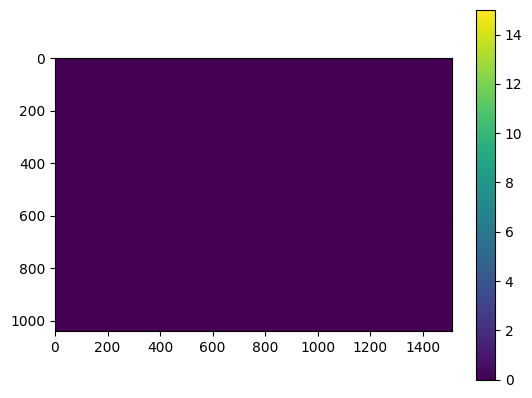

In [38]:
plt.imshow(output[0][0].cpu().detach().numpy())
plt.colorbar()

In [31]:
ids

['kidney_2_0000',
 'kidney_2_0001',
 'kidney_2_0002',
 'kidney_2_0003',
 'kidney_2_0004',
 'kidney_2_0005',
 'kidney_2_0006',
 'kidney_2_0007',
 'kidney_2_0008',
 'kidney_2_0009',
 'kidney_2_0010',
 'kidney_2_0011',
 'kidney_2_0012',
 'kidney_2_0013',
 'kidney_2_0014',
 'kidney_2_0015',
 'kidney_2_0016',
 'kidney_2_0017',
 'kidney_2_0018',
 'kidney_2_0019',
 'kidney_2_0020',
 'kidney_2_0021',
 'kidney_2_0022',
 'kidney_2_0023',
 'kidney_2_0024',
 'kidney_2_0025',
 'kidney_2_0026',
 'kidney_2_0027',
 'kidney_2_0028',
 'kidney_2_0029',
 'kidney_2_0030',
 'kidney_2_0031',
 'kidney_2_0032',
 'kidney_2_0033',
 'kidney_2_0034',
 'kidney_2_0035',
 'kidney_2_0036',
 'kidney_2_0037',
 'kidney_2_0038',
 'kidney_2_0039',
 'kidney_2_0040',
 'kidney_2_0041',
 'kidney_2_0042',
 'kidney_2_0043',
 'kidney_2_0044',
 'kidney_2_0045',
 'kidney_2_0046',
 'kidney_2_0047',
 'kidney_2_0048',
 'kidney_2_0049',
 'kidney_2_0050',
 'kidney_2_0051',
 'kidney_2_0052',
 'kidney_2_0053',
 'kidney_2_0054',
 'kidney_2

In [16]:
TH=[x.flatten().numpy() for x in output]
TH=np.concatenate(TH)
index = -int(len(TH)*CFG_Load.th_percentile)
TH:int=np.partition(TH,index)[index]
print(TH)

250


In [21]:
import pandas as pd

/tmp/ipykernel_20594/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
#ids = [list of files names (kidney_2_0000)]
# output = [list of single 3d tensor (torch.Size([2217, 1041, 1511])

In [48]:
img=cv2.imread("/root/data/train/kidney_2/images/0000.tif", cv2.IMREAD_GRAYSCALE)

submission_df=[]
for index in range(len(ids)):
    id=ids[index]
    i=0
    for x in output:
        if index>=len(x):
            index-=len(x)
            i+=1
        else:
            break
    mask_pred=(output[i][index]).numpy()
    mask_pred2 = to_original(mask_pred, img, image_size=1024)
    mask_pred = mask_pred2.copy()

    rle = rle_encode(mask_pred)

    submission_df.append(
        pd.DataFrame(data={
            'id' : id,
            'rle' : rle,
        }, index=[0])
    )

submission_df = pd.concat(submission_df)
submission_df.to_csv('submission_kidney_2_surface_dice.csv', index=False)
submission_df.head(6)

ValueError: could not broadcast input array from shape (12,13) into shape (12,)

In [43]:
output_np = output[0][0].numpy()

In [44]:
np.save("2d_segmentation", output_np)

In [99]:
output = np.load("/root/sennet-kaggle/src/util/2d_nn/2d_segmentation.npy")

In [11]:
output.shape

(2217, 1041, 1511)

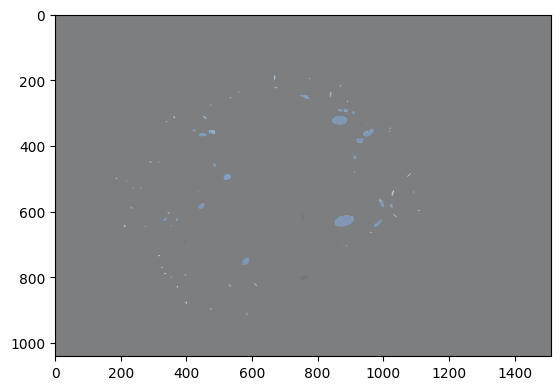

In [156]:
path = "/root/data/train/kidney_2/images/" # the path to the directory that contains the tiff files
file_list = os.listdir(path) # get the list of file names in the directory
lbls = "/root/data/train/kidney_2/labels/"
lbl_list = os.listdir(lbls)

i_1 = 1452
img = tiff.imread(path + file_list[i_1]) # read the 5th tiff file as a numpy array
lbl = tiff.imread(lbls + lbl_list[i_1])
gen = output[i_1,:,:]
#plt.imshow(img, cmap='grey')
plt.imshow(output[i_1,:,:], cmap="Blues")
plt.imshow(lbl, cmap="grey", alpha=0.5)


In [163]:
i_1 = 1200
bool = output[i_1,:,:]
bool = bool.astype(bool)
plt.imshow(bool, cmap="grey")

TypeError: Cannot construct a dtype from an array

In [184]:
thr = 0.501

#gen = gen.astype(np.float32) 
#gen = tc.from_numpy(gen)
lbl = tc.from_numpy(lbl)
img_c = gen.sigmoid()
lbl = lbl.sigmoid()
img_thr = (img_c > thr)
lbl_thr = (lbl > thr)
img_thr = img_thr.to(tc.float32)
lbl_thr = lbl_thr.to(tc.float32)
inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()


tensor(0.8894)

In [196]:
inter_new = (np.count_nonzero(img_c > 0.5) - (FN + FP))
inter_new

5488

In [189]:
test = img_thr - lbl_thr
FP = np.count_nonzero(test > 0)
test_FN = lbl_thr - img_thr
FN = np.count_nonzero(test_FN > 0)

In [192]:
print(inter_n), # true positive
print(FP), # False positive
print(FN) # False negative


tensor(5563.)
1309
75


In [ ]:
path = "/root/data/train/kidney_2/images/" # the path to the directory that contains the tiff files
file_list = os.listdir(path) # get the list of file names in the directory
lbls = "/root/data/train/kidney_2/labels/"
lbl_list = os.listdir(lbls)

i_1 = 1452
img = tiff.imread(path + file_list[i_1]) # read the 5th tiff file as a numpy array
lbl = tiff.imread(lbls + lbl_list[i_1])
gen = output[0][0][i_1,:,:]

thr = 0.501

#gen = gen.astype(np.float32) 
#gen = tc.from_numpy(gen)
lbl = tc.from_numpy(lbl)
img_c = gen.sigmoid()
lbl = lbl.sigmoid()
img_thr = (img_c > thr)
lbl_thr = (lbl > thr)
img_thr = img_thr.to(tc.float32)
lbl_thr = lbl_thr.to(tc.float32)
inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()

inter_new = (np.count_nonzero(img_c > 0.5) - (FN + FP))
inter_new

test = img_thr - lbl_thr
FP = np.count_nonzero(test > 0)
test_FN = lbl_thr - img_thr
FN = np.count_nonzero(test_FN > 0)

In [102]:
import numpy as np
import tifffile as tiff
import torch as tc

path = "/root/data/train/kidney_2/images/" # the path to the directory that contains the tiff files
file_list = os.listdir(path) # get the list of file names in the directory
lbls = "/root/data/train/kidney_2/labels/"
lbl_list = os.listdir(lbls)

thr = 0.75

inter_new_list = [] # a list to store the inter_new values for each file and label
FP_list = [] # a list to store the FP values for each file and label
FN_list = [] # a list to store the FN values for each file and label

for i in range(len(file_list)): # loop over all the file names and labels
    img = tiff.imread(path + file_list[i]) # works
    lbl = tiff.imread(lbls + lbl_list[i]) # works
    gen = output[i,:,:] # works

    #gen = gen.astype(np.float32) 
    #gen = tc.from_numpy(gen)
    lbl = tc.from_numpy(lbl)
    gen = tc.from_numpy(gen)
    img_c = gen.sigmoid()
    lbl = lbl.sigmoid()
    img_thr = (img_c > thr)
    lbl_thr = (lbl > thr)
    img_thr = img_thr.to(tc.float32)
    lbl_thr = lbl_thr.to(tc.float32)
    inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
    den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
    dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()

    test = img_thr - lbl_thr
    FP = np.count_nonzero(test > 0)
    FP_list.append(FP) # append the FP value to the list

    test_FN = lbl_thr - img_thr
    FN = np.count_nonzero(test_FN > 0)
    FN_list.append(FN) # append the FN value to the list

    inter_new = (np.count_nonzero(img_c > 0.75) - (FN + FP))
    inter_new_list.append(inter_new) # append the inter_new value to the list


print(inter_new_list) # print the list of inter_new values
print(FP_list) # print the list of FP values
print(FN_list) # print the list of FN values


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -1, -1, -1, -4, -4, -12, -9, -5, -5, -7, -7, -9, -9, -10, -8, -11, -11, -3, -8, 2, 5, 14, 20, 14, 5, 5, 1, -8, 1, -4, -5, 9, 11, 9, 12, -7, -4, 13, 11, -2, 6, 16, 6, 22, 3, 2, 12, 16, 38, 31, 36, 41, 41, 31, 55, 43, 57, 64, 55, 44, 34, 76, 104, 68, 84, 91, 80, 80, 84, 97, 90, 93, 97, 106, 123, 121, 123, 128, 164, 235, 192, 176, 180, 192, 209, 210, 235, 241, 246, 249, 264, 257, 266, 253, 256, 250, 253, 288, 337, 364, 298, 263, 309, 334, 283, 343, 327, 321, 343, 332, 334, 349, 390, 397, 392, 376, 381, 374, 375, 357, 363, 388, 382, 408, 378, 372, 393, 496, 564, 590, 593, 510, 535, 551, 532, 497, 555, 538, 548, 597, 578, 617, 638, 657, 680, 689, 689, 700, 709, 738, 728, 749, 769, 736, 790, 781, 769, 762, 767, 773, 741, 754, 753, 761, 768, 762, 756, 748, 777, 797, 820, 808, 1023, 1140, 1

In [117]:
i = 1245
img = tiff.imread(path + file_list[i]) # read the i-th tiff file as a numpy array
lbl = tiff.imread(lbls + lbl_list[i]) # read the i-th label as a numpy array
gen = output[i,:,:] # get the i-th output from the gen array


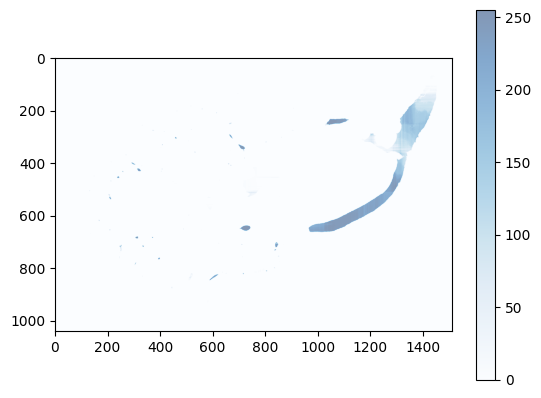

In [141]:
#plt.imshow(gen, cmap="grey")
plt.imshow(gen_c, cmap="Blues", alpha=0.5)
plt.colorbar()

In [144]:
gen_c = tc.from_numpy(gen)

In [146]:
gen_c = gen_c.type(tc.float)

In [148]:
gen_c = gen_c.sigmoid()

In [149]:
gen_c.min(), gen_c.max()

(tensor(0.5000), tensor(1.))

In [150]:
import math

In [151]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [155]:
sigmoid(-1)

0.2689414213699951

In [62]:
thr = 0.501

lbl = tc.from_numpy(lbl)
gen = tc.from_numpy(gen)
img_c = gen.sigmoid()
lbl = lbl.sigmoid()
img_thr = (img_c > thr)
lbl_thr = (lbl > thr)
img_thr = img_thr.to(tc.float32)
lbl_thr = lbl_thr.to(tc.float32)
inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()



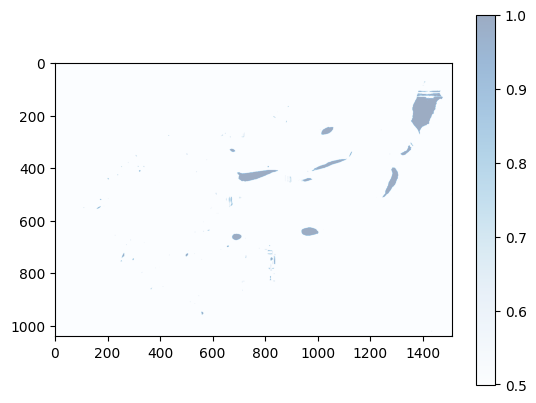

In [79]:
#plt.imshow(gen, cmap='grey')
plt.imshow(img_c, cmap='Blues', alpha=0.4)
#plt.imshow(img_thr, cmap='Blues', alpha=0.4)
#plt.imshow(lbl_thr, cmap="Blues", alpha=0.4)
plt.colorbar()

In [ ]:


test = img_thr - lbl_thr
FP = np.count_nonzero(test > 0)
#FP_list.append(FP) # append the FP value to the list

test_FN = lbl_thr - img_thr
FN = np.count_nonzero(test_FN > 0)
#FN_list.append(FN) # append the FN value to the list

inter_new = (np.count_nonzero(img_c > 0.5) - (FN + FP))
#inter_new_list.append(inter_new) # append the inter_new value to the list

In [103]:
sum1 = sum(inter_new_list) 
sum1

13274439

In [104]:
sum2 = sum(FP_list)
sum2

4340388

In [105]:
sum3 = sum(FN_list)
sum3

507035